# PTM Site Data Analysis

Analysis of Post-Translational Modification (PTM) site datasets to extract key insights and trends.

## Dataset Overview
- **acet_k**: Acetylation at Lysine (K)
- **crot_k**: Crotonylation at Lysine (K)
- **gly_n**: Glycosylation at Asparagine (N)
- **phos_y**: Phosphorylation at Tyrosine (Y)
- **sumo_k**: SUMOylation at Lysine (K)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from collections import Counter
from scipy import stats
warnings.filterwarnings('ignore')

# Set style for better visualizations
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Define dataset paths
DATA_DIR = Path('../datasets')
OUTPUT_DIR = Path('../docs')
OUTPUT_DIR.mkdir(exist_ok=True)

Matplotlib is building the font cache; this may take a moment.


## 1. Data Loading and Initial Exploration

In [2]:
# Load all datasets
datasets = {}

ptm_types = ['acet_k', 'crot_k', 'gly_n', 'phos_y', 'sumo_k']

for ptm_type in ptm_types:
    train_path = DATA_DIR / f'{ptm_type}_train.csv'
    test_path = DATA_DIR / f'{ptm_type}_test.csv'
    
    if train_path.exists():
        datasets[f'{ptm_type}_train'] = pd.read_csv(train_path)
    if test_path.exists():
        datasets[f'{ptm_type}_test'] = pd.read_csv(test_path)

print("Loaded datasets:")
for name, df in datasets.items():
    print(f"  {name}: {len(df)} rows, {len(df.columns)} columns")

Loaded datasets:
  acet_k_train: 63300 rows, 13 columns
  acet_k_test: 5559 rows, 13 columns
  crot_k_train: 13948 rows, 4 columns
  crot_k_test: 4825 rows, 4 columns
  gly_n_train: 14558 rows, 13 columns
  gly_n_test: 1698 rows, 13 columns
  phos_y_train: 58721 rows, 13 columns
  phos_y_test: 5814 rows, 13 columns
  sumo_k_train: 71453 rows, 13 columns
  sumo_k_test: 8615 rows, 13 columns


In [3]:
# Examine structure of different dataset types
print("=" * 80)
print("Dataset Structure Comparison")
print("=" * 80)

# Check standard format (acet_k, gly_n, phos_y, sumo_k)
if 'acet_k_train' in datasets:
    print("\nStandard format (acet_k, gly_n, phos_y, sumo_k):")
    print(datasets['acet_k_train'].head(3))
    print(f"\nColumns: {list(datasets['acet_k_train'].columns)}")
    print(f"\nData types:\n{datasets['acet_k_train'].dtypes}")
    print(f"\nMissing values:\n{datasets['acet_k_train'].isnull().sum()}")

# Check crot_k format (different structure)
if 'crot_k_train' in datasets:
    print("\n\nCrotonylation format (crot_k):")
    print(datasets['crot_k_train'].head(3))
    print(f"\nColumns: {list(datasets['crot_k_train'].columns)}")
    print(f"\nData types:\n{datasets['crot_k_train'].dtypes}")
    print(f"\nMissing values:\n{datasets['crot_k_train'].isnull().sum()}")

Dataset Structure Comparison

Standard format (acet_k, gly_n, phos_y, sumo_k):
                                   original_sequence  ptm_type UniProt_ID  \
0  DSDSDMADVTARSLQYEYKANSNLVLQADRSLIDRTRRDEPTGEVL...         1     O75643   
1  TARSLQYEYKANSNLVLQADRSLIDRTRRDEPTGEVLSLVGKLEGT...         1     O75643   
2  MVGIIYKPKTKETRETYEVLLSFIQAALGDQPRDILCGAADEVLAV...         1     O75643   

   embedding_dispersion  center_window_dispersion  embedding_entropy  \
0              0.907053                  0.855988           2.259217   
1              0.910117                  0.858511           2.232487   
2              0.909443                  0.846042           2.130990   

   center_window_entropy  svd_entropy  center_svd_entropy  cluster  \
0               2.342132     0.813263            0.850098      1.0   
1               2.293507     0.819403            0.860423      1.0   
2               2.171608     0.825880            0.880632      1.0   

  cluster_label  LCR_prob  HCR_prob  
0   

## 2. Dataset Statistics and Overview

In [4]:
# Create summary statistics
summary_stats = []

for name, df in datasets.items():
    ptm_type = name.split('_')[0] + '_' + name.split('_')[1]
    split = name.split('_', 2)[2] if len(name.split('_')) > 2 else 'unknown'
    
    stats = {
        'PTM_Type': ptm_type,
        'Split': split,
        'Total_Samples': len(df),
        'Num_Features': len(df.columns),
        'Unique_Proteins': df['UniProt_ID'].nunique() if 'UniProt_ID' in df.columns else 'N/A'
    }
    
    # Check for ptm_type column (binary label)
    if 'ptm_type' in df.columns:
        stats['PTM_Sites'] = (df['ptm_type'] == 1).sum()
        stats['Non_PTM_Sites'] = (df['ptm_type'] == 0).sum()
        stats['PTM_Ratio'] = stats['PTM_Sites'] / stats['Total_Samples'] if stats['Total_Samples'] > 0 else 0
        stats['Class_Imbalance_Ratio'] = stats['Non_PTM_Sites'] / stats['PTM_Sites'] if stats['PTM_Sites'] > 0 else np.inf
    
    # Sequence length statistics
    if 'original_sequence' in df.columns:
        seq_lengths = df['original_sequence'].str.len()
        stats['Mean_Seq_Length'] = seq_lengths.mean()
        stats['Std_Seq_Length'] = seq_lengths.std()
        stats['Min_Seq_Length'] = seq_lengths.min()
        stats['Max_Seq_Length'] = seq_lengths.max()
    
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
print("Dataset Summary Statistics:")
print(summary_df.to_string(index=False))

Dataset Summary Statistics:
PTM_Type Split  Total_Samples  Num_Features  Unique_Proteins  PTM_Sites  Non_PTM_Sites  PTM_Ratio  Class_Imbalance_Ratio  Mean_Seq_Length  Std_Seq_Length  Min_Seq_Length  Max_Seq_Length
  acet_k train          63300            13             6089      30053          33247   0.474771               1.106279       100.904834        1.729430              45             101
  acet_k  test           5559            13              666       2836           2723   0.510164               0.960155       100.829106        1.962295              55             101
  crot_k train          13948             4             3114       6974           6974   0.500000               1.000000        51.000000        0.000000              51              51
  crot_k  test           4825             4             2130       2887           1938   0.598342               0.671285        51.000000        0.000000              51              51
   gly_n train          14558            1

## 3. Class Imbalance Analysis

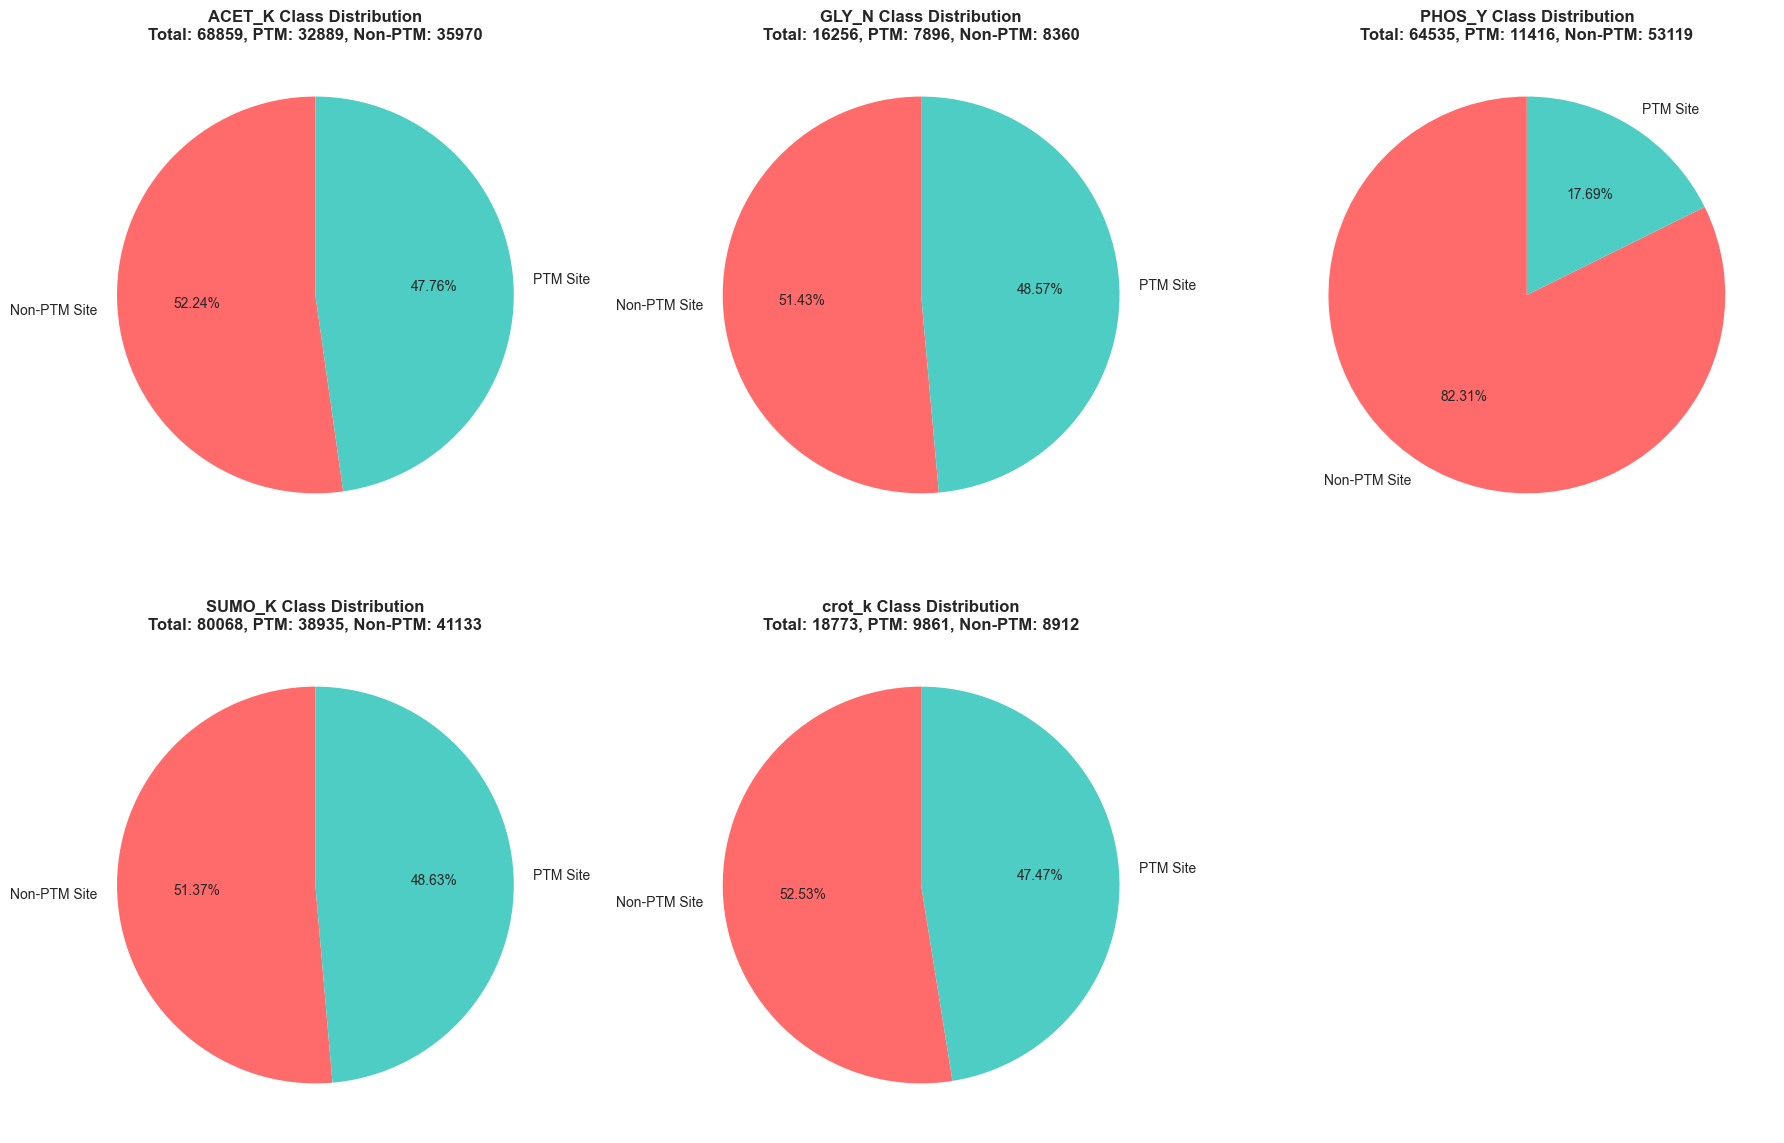


Class Imbalance Ratios (Non-PTM : PTM):
PTM_Type  PTM_Sites  Non_PTM_Sites Imbalance_Ratio
  acet_k      32889          35970          1.09:1
   gly_n       7896           8360          1.06:1
  phos_y      11416          53119          4.65:1
  sumo_k      38935          41133          1.06:1
  crot_k       9861           8912          0.90:1


In [5]:
# Analyze class imbalance for each PTM type
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

ptm_types_standard = ['acet_k', 'gly_n', 'phos_y', 'sumo_k']
plot_idx = 0

for ptm_type in ptm_types_standard:
    train_key = f'{ptm_type}_train'
    test_key = f'{ptm_type}_test'
    
    if train_key in datasets:
        df_train = datasets[train_key]
        df_test = datasets[test_key] if test_key in datasets else None
        
        # Combine train and test for overall statistics
        if df_test is not None:
            df_combined = pd.concat([df_train, df_test], ignore_index=True)
        else:
            df_combined = df_train
        
        if 'ptm_type' in df_combined.columns:
            ptm_counts = df_combined['ptm_type'].value_counts()
            
            ax = axes[plot_idx]
            colors = ['#ff6b6b', '#4ecdc4']
            labels = ['Non-PTM Site', 'PTM Site']
            
            ax.pie(ptm_counts.values, labels=labels, autopct='%1.2f%%', 
                   colors=colors, startangle=90, textprops={'fontsize': 10})
            ax.set_title(f'{ptm_type.upper()} Class Distribution\n'
                         f'Total: {len(df_combined)}, PTM: {ptm_counts.get(1, 0)}, '
                         f'Non-PTM: {ptm_counts.get(0, 0)}', 
                         fontsize=12, fontweight='bold')
            plot_idx += 1

# Handle crot_k separately if it exists
if 'crot_k_train' in datasets:
    df_train = datasets['crot_k_train']
    df_test = datasets.get('crot_k_test', None)
    
    if df_test is not None:
        df_combined = pd.concat([df_train, df_test], ignore_index=True)
    else:
        df_combined = df_train
    
    if 'ptm_type' in df_combined.columns:
        ptm_counts = df_combined['ptm_type'].value_counts()
        
        ax = axes[plot_idx]
        colors = ['#ff6b6b', '#4ecdc4']
        labels = ['Non-PTM Site', 'PTM Site']
        
        ax.pie(ptm_counts.values, labels=labels, autopct='%1.2f%%', 
               colors=colors, startangle=90, textprops={'fontsize': 10})
        ax.set_title(f'crot_k Class Distribution\n'
                     f'Total: {len(df_combined)}, PTM: {ptm_counts.get(1, 0)}, '
                     f'Non-PTM: {ptm_counts.get(0, 0)}', 
                     fontsize=12, fontweight='bold')
        plot_idx += 1

# Remove empty subplots
for idx in range(plot_idx, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'ptm_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClass Imbalance Ratios (Non-PTM : PTM):")
imbalance_data = []
for ptm_type in ptm_types_standard + ['crot_k']:
    train_key = f'{ptm_type}_train'
    test_key = f'{ptm_type}_test'
    
    if train_key in datasets:
        df_train = datasets[train_key]
        df_test = datasets[test_key] if test_key in datasets else None
        
        if df_test is not None:
            df_combined = pd.concat([df_train, df_test], ignore_index=True)
        else:
            df_combined = df_train
        
        if 'ptm_type' in df_combined.columns:
            ptm_sites = (df_combined['ptm_type'] == 1).sum()
            non_ptm_sites = (df_combined['ptm_type'] == 0).sum()
            ratio = non_ptm_sites / ptm_sites if ptm_sites > 0 else np.inf
            
            imbalance_data.append({
                'PTM_Type': ptm_type,
                'PTM_Sites': ptm_sites,
                'Non_PTM_Sites': non_ptm_sites,
                'Imbalance_Ratio': f"{ratio:.2f}:1"
            })

imbalance_df = pd.DataFrame(imbalance_data)
print(imbalance_df.to_string(index=False))

## 4. Sequence Length Analysis

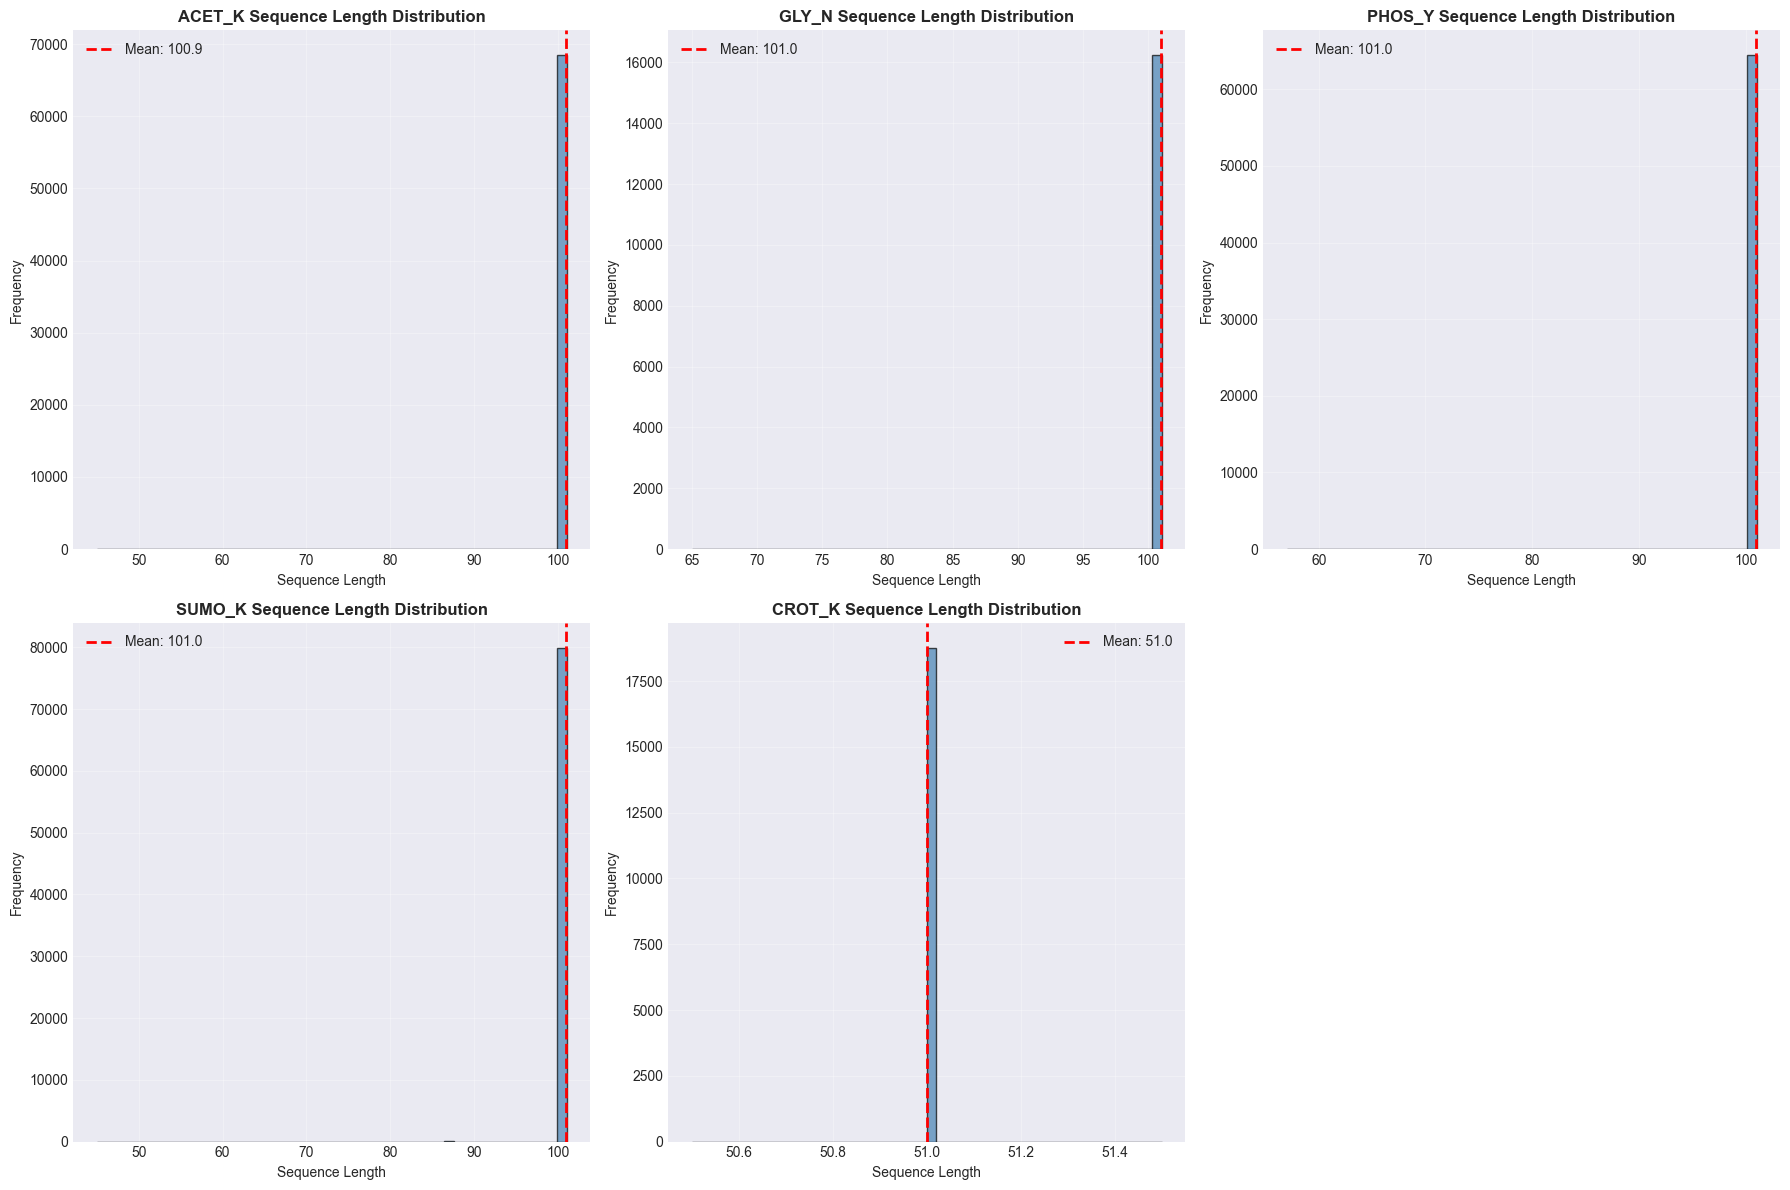


Sequence Length Statistics:
PTM_Type       Mean  Median      Std  Min  Max   Q25   Q75
  acet_k 100.898721   101.0 1.749486   45  101 101.0 101.0
   gly_n 100.977239   101.0 0.707632   65  101 101.0 101.0
  phos_y 100.980383   101.0 0.701034   57  101 101.0 101.0
  sumo_k 100.973772   101.0 0.814344   45  101 101.0 101.0
  crot_k  51.000000    51.0 0.000000   51   51  51.0  51.0


In [6]:
# Analyze sequence length distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

plot_idx = 0
seq_length_stats = []

for ptm_type in ptm_types_standard + ['crot_k']:
    train_key = f'{ptm_type}_train'
    test_key = f'{ptm_type}_test'
    
    if train_key in datasets:
        df_train = datasets[train_key]
        df_test = datasets[test_key] if test_key in datasets else None
        
        if df_test is not None:
            df_combined = pd.concat([df_train, df_test], ignore_index=True)
        else:
            df_combined = df_train
        
        if 'original_sequence' in df_combined.columns:
            seq_lengths = df_combined['original_sequence'].str.len()
            
            ax = axes[plot_idx]
            ax.hist(seq_lengths, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
            ax.axvline(seq_lengths.mean(), color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {seq_lengths.mean():.1f}')
            ax.set_xlabel('Sequence Length', fontsize=10)
            ax.set_ylabel('Frequency', fontsize=10)
            ax.set_title(f'{ptm_type.upper()} Sequence Length Distribution', 
                        fontsize=12, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            seq_length_stats.append({
                'PTM_Type': ptm_type,
                'Mean': seq_lengths.mean(),
                'Median': seq_lengths.median(),
                'Std': seq_lengths.std(),
                'Min': seq_lengths.min(),
                'Max': seq_lengths.max(),
                'Q25': seq_lengths.quantile(0.25),
                'Q75': seq_lengths.quantile(0.75)
            })
            
            plot_idx += 1

# Remove empty subplots
for idx in range(plot_idx, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('../docs/sequence_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

seq_length_df = pd.DataFrame(seq_length_stats)
print("\nSequence Length Statistics:")
print(seq_length_df.to_string(index=False))

## 5. Feature Analysis (Embedding and Entropy Features)

In [7]:
# Analyze feature distributions for standard format datasets
feature_columns = ['embedding_dispersion', 'center_window_dispersion', 
                   'embedding_entropy', 'center_window_entropy',
                   'svd_entropy', 'center_svd_entropy']

# Create feature comparison across PTM types
feature_stats = []

for ptm_type in ptm_types_standard:
    train_key = f'{ptm_type}_train'
    test_key = f'{ptm_type}_test'
    
    if train_key in datasets:
        df_train = datasets[train_key]
        df_test = datasets[test_key] if test_key in datasets else None
        
        if df_test is not None:
            df_combined = pd.concat([df_train, df_test], ignore_index=True)
        else:
            df_combined = df_train
        
        for feature in feature_columns:
            if feature in df_combined.columns:
                feature_data = df_combined[feature]
                
                # Separate by PTM status if available
                if 'ptm_type' in df_combined.columns:
                    ptm_values = df_combined[df_combined['ptm_type'] == 1][feature]
                    non_ptm_values = df_combined[df_combined['ptm_type'] == 0][feature]
                    
                    feature_stats.append({
                        'PTM_Type': ptm_type,
                        'Feature': feature,
                        'Category': 'PTM_Site',
                        'Mean': ptm_values.mean(),
                        'Std': ptm_values.std(),
                        'Median': ptm_values.median()
                    })
                    
                    feature_stats.append({
                        'PTM_Type': ptm_type,
                        'Feature': feature,
                        'Category': 'Non_PTM_Site',
                        'Mean': non_ptm_values.mean(),
                        'Std': non_ptm_values.std(),
                        'Median': non_ptm_values.median()
                    })
                else:
                    feature_stats.append({
                        'PTM_Type': ptm_type,
                        'Feature': feature,
                        'Category': 'All',
                        'Mean': feature_data.mean(),
                        'Std': feature_data.std(),
                        'Median': feature_data.median()
                    })

feature_stats_df = pd.DataFrame(feature_stats)
print("\nFeature Statistics Summary:")
print(feature_stats_df.head(20).to_string(index=False))


Feature Statistics Summary:
PTM_Type                  Feature     Category     Mean      Std   Median
  acet_k     embedding_dispersion     PTM_Site 0.906968 0.020764 0.910104
  acet_k     embedding_dispersion Non_PTM_Site 0.903183 0.024812 0.908007
  acet_k center_window_dispersion     PTM_Site 0.847425 0.038784 0.855236
  acet_k center_window_dispersion Non_PTM_Site 0.842831 0.044261 0.853048
  acet_k        embedding_entropy     PTM_Site 2.065615 0.209378 2.034858
  acet_k        embedding_entropy Non_PTM_Site 2.128947 0.237274 2.101802
  acet_k    center_window_entropy     PTM_Site 2.172860 0.204071 2.149429
  acet_k    center_window_entropy Non_PTM_Site 2.237401 0.225855 2.214106
  acet_k              svd_entropy     PTM_Site 0.851890 0.045262 0.861453
  acet_k              svd_entropy Non_PTM_Site 0.835297 0.058983 0.847299
  acet_k       center_svd_entropy     PTM_Site 0.881787 0.044176 0.891548
  acet_k       center_svd_entropy Non_PTM_Site 0.863832 0.060483 0.878244
   gly_n 

## 6. Cluster and Probability Analysis

In [10]:
# Analyze cluster labels and probabilities
cluster_analysis = []

for ptm_type in ptm_types_standard:
    train_key = f'{ptm_type}_train'
    test_key = f'{ptm_type}_test'
    
    if train_key in datasets:
        df_train = datasets[train_key]
        df_test = datasets[test_key] if test_key in datasets else None
        
        if df_test is not None:
            df_combined = pd.concat([df_train, df_test], ignore_index=True)
        else:
            df_combined = df_train
        
        if 'cluster_label' in df_combined.columns:
            cluster_dist = df_combined['cluster_label'].value_counts()
            
            cluster_analysis.append({
                'PTM_Type': ptm_type,
                'HCR_Count': cluster_dist.get('HCR', 0),
                'LCR_Count': cluster_dist.get('LCR', 0),
                'HCR_Percentage': (cluster_dist.get('HCR', 0) / len(df_combined)) * 100,
                'LCR_Percentage': (cluster_dist.get('LCR', 0) / len(df_combined)) * 100
            })
        
        # Analyze probability distributions
        if 'LCR_prob' in df_combined.columns and 'HCR_prob' in df_combined.columns:
            lcr_mean = df_combined['LCR_prob'].mean()
            hcr_mean = df_combined['HCR_prob'].mean()
            
            if 'PTM_Type' not in [c['PTM_Type'] for c in cluster_analysis if 'PTM_Type' in c]:
                cluster_analysis.append({
                    'PTM_Type': ptm_type,
                    'HCR_Count': 'N/A',
                    'LCR_Count': 'N/A',
                    'HCR_Percentage': 'N/A',
                    'LCR_Percentage': 'N/A'
                })
            
            # Add probability info
            for item in cluster_analysis:
                if item['PTM_Type'] == ptm_type:
                    item['Mean_LCR_Prob'] = lcr_mean
                    item['Mean_HCR_Prob'] = hcr_mean
                    break

cluster_df = pd.DataFrame(cluster_analysis)
print("\nCluster and Probability Analysis:")
print(cluster_df.to_string(index=False))


Cluster and Probability Analysis:
PTM_Type HCR_Count LCR_Count HCR_Percentage LCR_Percentage  Mean_LCR_Prob  Mean_HCR_Prob
  acet_k     51128     17731       74.25028       25.74972       0.289425       0.710575
  acet_k       N/A       N/A            N/A            N/A            NaN            NaN
   gly_n     12811      3445      78.807825      21.192175       0.232831       0.767169
   gly_n       N/A       N/A            N/A            N/A            NaN            NaN
  phos_y     50743     13792      78.628651      21.371349       0.255896       0.744104
  phos_y       N/A       N/A            N/A            N/A            NaN            NaN
  sumo_k     59495     20573       74.30559       25.69441       0.294057       0.705943
  sumo_k       N/A       N/A            N/A            N/A            NaN            NaN


## 7. Protein-Level Analysis (UniProt ID Distribution)

In [11]:
# Analyze protein distribution
protein_stats = []

for ptm_type in ptm_types_standard + ['crot_k']:
    train_key = f'{ptm_type}_train'
    test_key = f'{ptm_type}_test'
    
    if train_key in datasets:
        df_train = datasets[train_key]
        df_test = datasets[test_key] if test_key in datasets else None
        
        if df_test is not None:
            df_combined = pd.concat([df_train, df_test], ignore_index=True)
        else:
            df_combined = df_train
        
        if 'UniProt_ID' in df_combined.columns:
            unique_proteins = df_combined['UniProt_ID'].nunique()
            total_samples = len(df_combined)
            samples_per_protein = total_samples / unique_proteins if unique_proteins > 0 else 0
            
            # Count PTM sites per protein
            if 'ptm_type' in df_combined.columns:
                ptm_per_protein = df_combined[df_combined['ptm_type'] == 1].groupby('UniProt_ID').size()
                avg_ptm_per_protein = ptm_per_protein.mean() if len(ptm_per_protein) > 0 else 0
                max_ptm_per_protein = ptm_per_protein.max() if len(ptm_per_protein) > 0 else 0
            else:
                avg_ptm_per_protein = 'N/A'
                max_ptm_per_protein = 'N/A'
            
            protein_stats.append({
                'PTM_Type': ptm_type,
                'Unique_Proteins': unique_proteins,
                'Total_Samples': total_samples,
                'Avg_Samples_per_Protein': f"{samples_per_protein:.2f}",
                'Avg_PTM_Sites_per_Protein': f"{avg_ptm_per_protein:.2f}" if avg_ptm_per_protein != 'N/A' else 'N/A',
                'Max_PTM_Sites_per_Protein': max_ptm_per_protein
            })

protein_df = pd.DataFrame(protein_stats)
print("\nProtein-Level Statistics:")
print(protein_df.to_string(index=False))


Protein-Level Statistics:
PTM_Type  Unique_Proteins  Total_Samples Avg_Samples_per_Protein Avg_PTM_Sites_per_Protein  Max_PTM_Sites_per_Protein
  acet_k             6755          68859                   10.19                      4.87                        155
   gly_n             2989          16256                    5.44                      2.64                         41
  phos_y             4861          64535                   13.28                      2.35                        115
  sumo_k             6353          80068                   12.60                      6.13                        130
  crot_k             3481          18773                    5.39                      2.90                         43


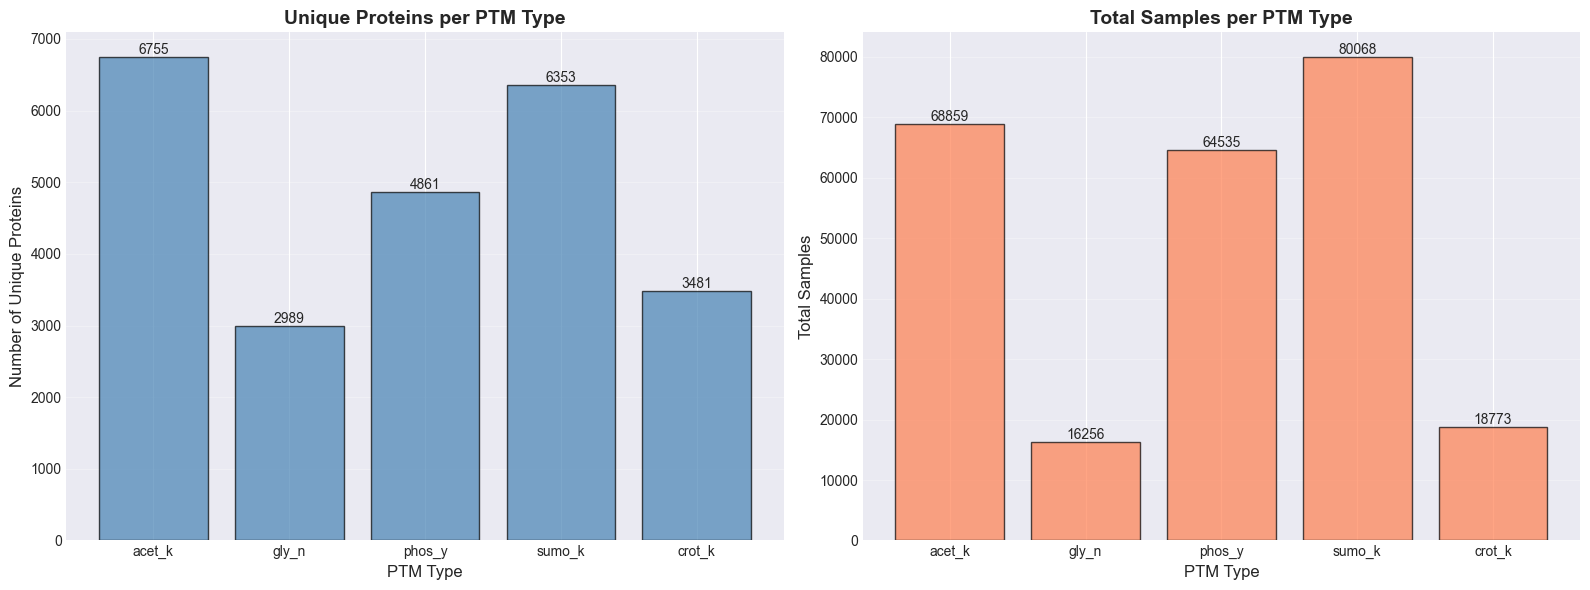

In [12]:
# Visualize protein distribution
if protein_stats:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    ptm_types_list = [s['PTM_Type'] for s in protein_stats]
    unique_proteins = [s['Unique_Proteins'] for s in protein_stats]
    total_samples = [s['Total_Samples'] for s in protein_stats]
    
    # Plot 1: Unique proteins per PTM type
    ax1 = axes[0]
    bars1 = ax1.bar(ptm_types_list, unique_proteins, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.set_xlabel('PTM Type', fontsize=12)
    ax1.set_ylabel('Number of Unique Proteins', fontsize=12)
    ax1.set_title('Unique Proteins per PTM Type', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Total samples per PTM type
    ax2 = axes[1]
    bars2 = ax2.bar(ptm_types_list, total_samples, color='coral', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('PTM Type', fontsize=12)
    ax2.set_ylabel('Total Samples', fontsize=12)
    ax2.set_title('Total Samples per PTM Type', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'protein_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

## 8. Cross-PTM Type Comparison

In [13]:
# Create comprehensive comparison across PTM types
comparison_data = []

for ptm_type in ptm_types_standard + ['crot_k']:
    train_key = f'{ptm_type}_train'
    test_key = f'{ptm_type}_test'
    
    if train_key in datasets:
        df_train = datasets[train_key]
        df_test = datasets[test_key] if test_key in datasets else None
        
        if df_test is not None:
            df_combined = pd.concat([df_train, df_test], ignore_index=True)
        else:
            df_combined = df_train
        
        stats = {'PTM_Type': ptm_type}
        
        # Basic statistics
        stats['Total_Samples'] = len(df_combined)
        
        if 'UniProt_ID' in df_combined.columns:
            stats['Unique_Proteins'] = df_combined['UniProt_ID'].nunique()
        
        if 'ptm_type' in df_combined.columns:
            stats['PTM_Sites'] = (df_combined['ptm_type'] == 1).sum()
            stats['Non_PTM_Sites'] = (df_combined['ptm_type'] == 0).sum()
            stats['PTM_Percentage'] = (stats['PTM_Sites'] / stats['Total_Samples']) * 100
        
        if 'original_sequence' in df_combined.columns:
            seq_lengths = df_combined['original_sequence'].str.len()
            stats['Mean_Seq_Length'] = seq_lengths.mean()
        
        comparison_data.append(stats)

comparison_df = pd.DataFrame(comparison_data)
print("\nCross-PTM Type Comparison:")
print(comparison_df.to_string(index=False))


Cross-PTM Type Comparison:
PTM_Type  Total_Samples  Unique_Proteins  PTM_Sites  Non_PTM_Sites  PTM_Percentage  Mean_Seq_Length
  acet_k          68859             6755      32889          35970       47.762820       100.898721
   gly_n          16256             2989       7896           8360       48.572835       100.977239
  phos_y          64535             4861      11416          53119       17.689626       100.980383
  sumo_k          80068             6353      38935          41133       48.627417       100.973772
  crot_k          18773             3481       9861           8912       52.527566        51.000000


## 9. Key Insights and Trends Summary

## 10. Amino Acid Composition Analysis

In [14]:
# Analyze amino acid composition around PTM sites
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')

def get_aa_composition(sequence):
    """Calculate amino acid composition of a sequence"""
    seq_upper = sequence.upper()
    composition = {aa: seq_upper.count(aa) / len(seq_upper) if len(seq_upper) > 0 else 0 
                   for aa in amino_acids}
    return composition

def get_position_specific_aa(sequence, position, window=5):
    """Get amino acids at specific positions relative to center"""
    seq_upper = sequence.upper()
    center = len(seq_upper) // 2
    start = max(0, center - window)
    end = min(len(seq_upper), center + window + 1)
    return seq_upper[start:end]

aa_composition_analysis = []

for ptm_type in ['acet_k', 'gly_n', 'phos_y', 'sumo_k']:
    train_key = f'{ptm_type}_train'
    test_key = f'{ptm_type}_test'
    
    if train_key in datasets:
        df_train = datasets[train_key]
        df_test = datasets[test_key] if test_key in datasets else None
        
        if df_test is not None:
            df_combined = pd.concat([df_train, df_test], ignore_index=True)
        else:
            df_combined = df_train
        
        if 'original_sequence' in df_combined.columns and 'ptm_type' in df_combined.columns:
            # Separate PTM and non-PTM sites
            ptm_seqs = df_combined[df_combined['ptm_type'] == 1]['original_sequence']
            non_ptm_seqs = df_combined[df_combined['ptm_type'] == 0]['original_sequence']
            
            # Calculate composition for PTM sites
            ptm_compositions = [get_aa_composition(seq) for seq in ptm_seqs]
            ptm_aa_df = pd.DataFrame(ptm_compositions)
            ptm_aa_mean = ptm_aa_df.mean()
            
            # Calculate composition for non-PTM sites
            non_ptm_compositions = [get_aa_composition(seq) for seq in non_ptm_seqs]
            non_ptm_aa_df = pd.DataFrame(non_ptm_compositions)
            non_ptm_aa_mean = non_ptm_aa_df.mean()
            
            # Find most discriminative amino acids
            aa_diff = ptm_aa_mean - non_ptm_aa_mean
            top_enriched = aa_diff.nlargest(5)
            top_depleted = aa_diff.nsmallest(5)
            
            aa_composition_analysis.append({
                'PTM_Type': ptm_type,
                'Top_Enriched_AAs': ', '.join([f"{aa}({val:.4f})" for aa, val in top_enriched.items()]),
                'Top_Depleted_AAs': ', '.join([f"{aa}({val:.4f})" for aa, val in top_depleted.items()]),
                'PTM_Seq_Count': len(ptm_seqs),
                'Non_PTM_Seq_Count': len(non_ptm_seqs)
            })

aa_comp_df = pd.DataFrame(aa_composition_analysis)
print("Amino Acid Composition Analysis:")
print(aa_comp_df.to_string(index=False))

Amino Acid Composition Analysis:
PTM_Type                                      Top_Enriched_AAs                                           Top_Depleted_AAs  PTM_Seq_Count  Non_PTM_Seq_Count
  acet_k A(0.0071), L(0.0065), G(0.0065), F(0.0040), Y(0.0032) K(-0.0123), E(-0.0114), S(-0.0070), P(-0.0056), T(-0.0019)          32889              35970
   gly_n L(0.0106), R(0.0051), A(0.0050), K(0.0035), Q(0.0018) C(-0.0094), N(-0.0072), D(-0.0068), G(-0.0045), I(-0.0040)           7896               8360
  phos_y P(0.0089), S(0.0082), G(0.0079), R(0.0074), E(0.0050) L(-0.0132), F(-0.0067), I(-0.0066), C(-0.0054), V(-0.0052)          11416              53119
  sumo_k A(0.0057), G(0.0052), L(0.0050), V(0.0046), P(0.0020) K(-0.0151), S(-0.0064), C(-0.0027), H(-0.0027), E(-0.0026)          38935              41133


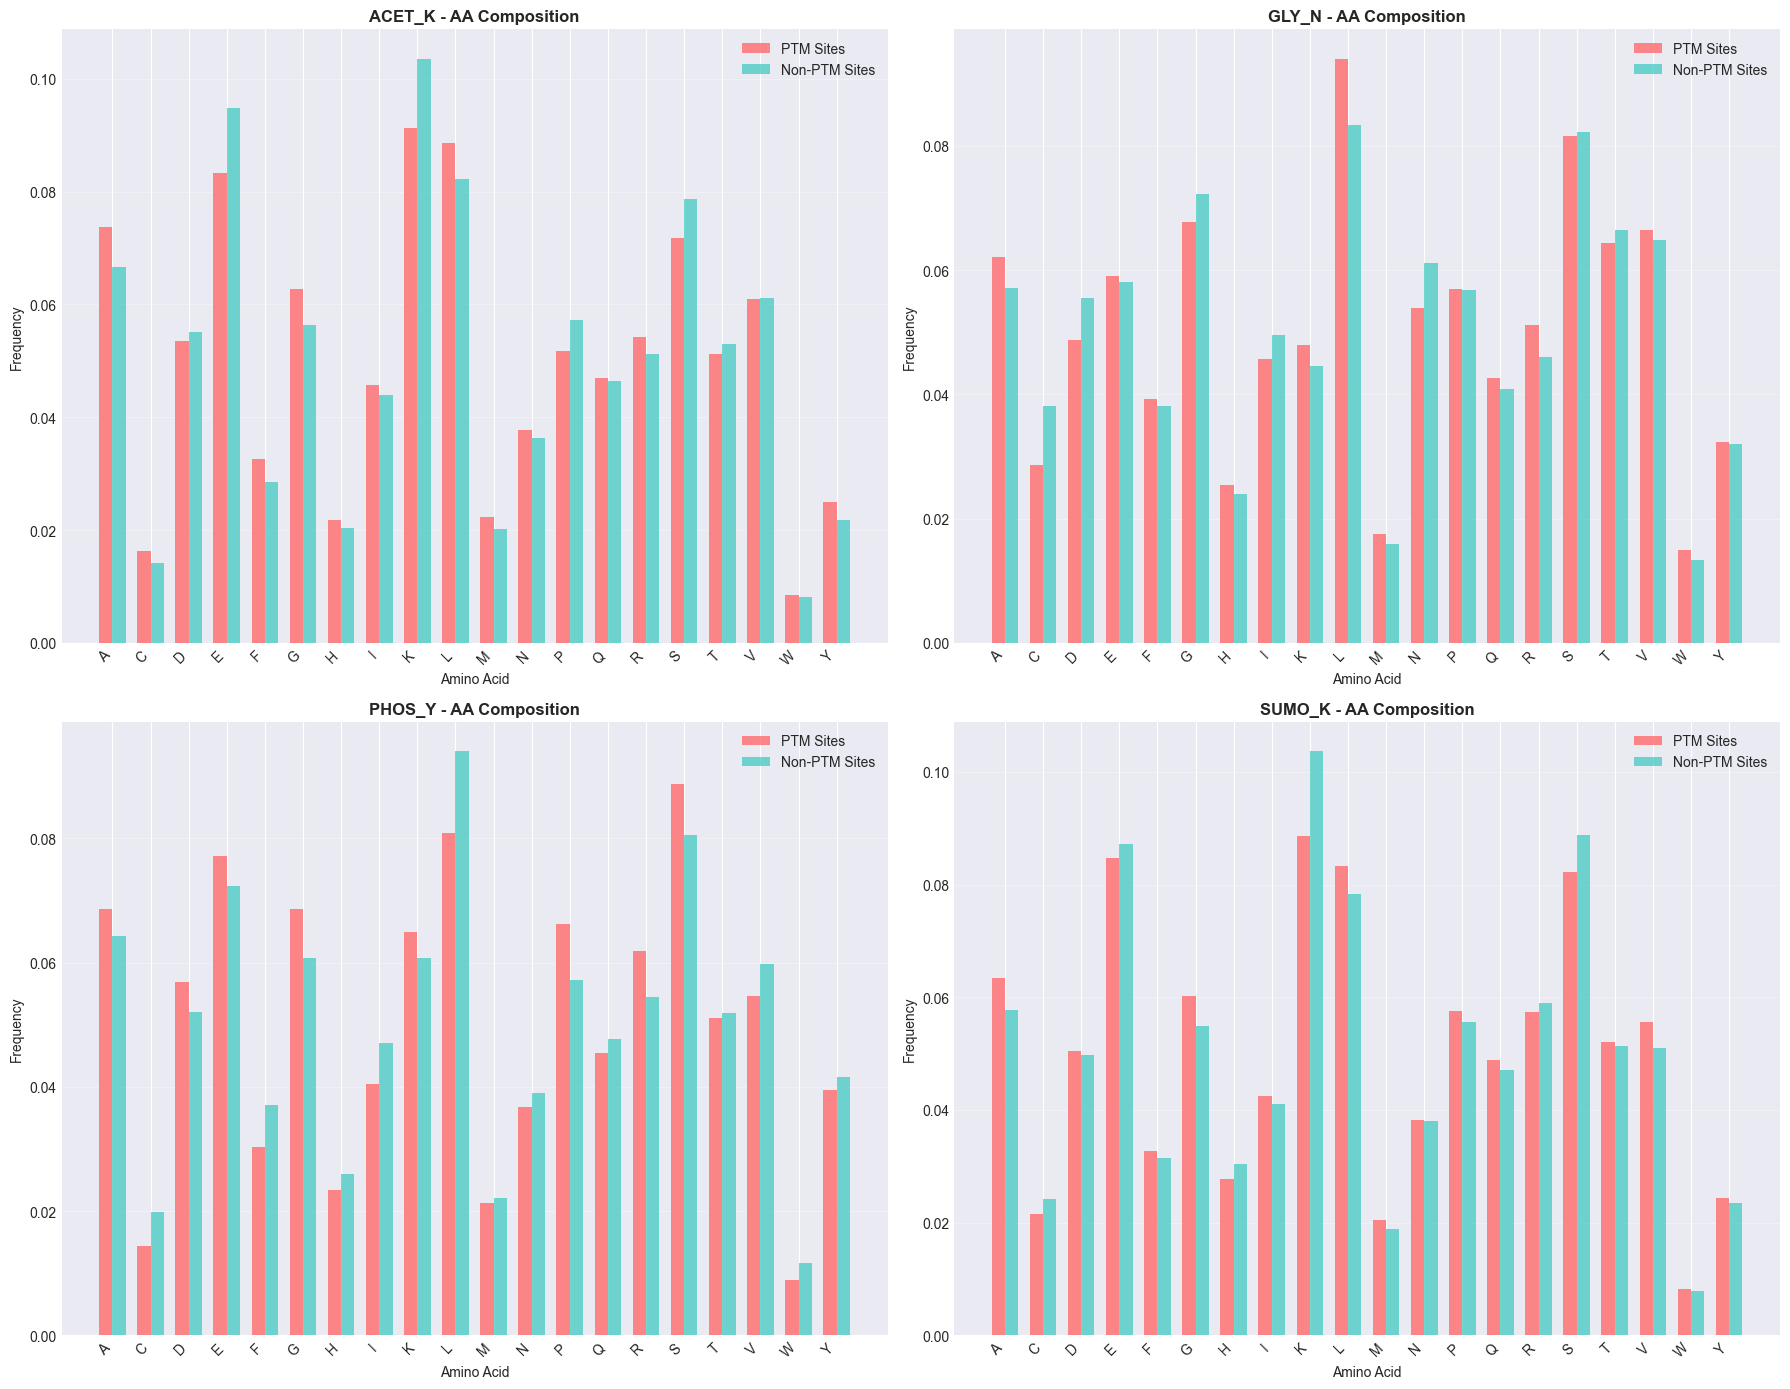

In [15]:
# Visualize amino acid composition differences
if len(aa_composition_analysis) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()
    
    plot_idx = 0
    for ptm_type in ['acet_k', 'gly_n', 'phos_y', 'sumo_k']:
        if plot_idx >= 4:
            break
            
        train_key = f'{ptm_type}_train'
        test_key = f'{ptm_type}_test'
        
        if train_key in datasets:
            df_train = datasets[train_key]
            df_test = datasets[test_key] if test_key in datasets else None
            
            if df_test is not None:
                df_combined = pd.concat([df_train, df_test], ignore_index=True)
            else:
                df_combined = df_train
            
            if 'original_sequence' in df_combined.columns and 'ptm_type' in df_combined.columns:
                ptm_seqs = df_combined[df_combined['ptm_type'] == 1]['original_sequence']
                non_ptm_seqs = df_combined[df_combined['ptm_type'] == 0]['original_sequence']
                
                ptm_compositions = [get_aa_composition(seq) for seq in ptm_seqs]
                non_ptm_compositions = [get_aa_composition(seq) for seq in non_ptm_seqs]
                
                ptm_aa_mean = pd.DataFrame(ptm_compositions).mean()
                non_ptm_aa_mean = pd.DataFrame(non_ptm_compositions).mean()
                
                ax = axes[plot_idx]
                x_pos = np.arange(len(amino_acids))
                width = 0.35
                
                ax.bar(x_pos - width/2, [ptm_aa_mean.get(aa, 0) for aa in amino_acids], 
                       width, label='PTM Sites', alpha=0.8, color='#ff6b6b')
                ax.bar(x_pos + width/2, [non_ptm_aa_mean.get(aa, 0) for aa in amino_acids], 
                       width, label='Non-PTM Sites', alpha=0.8, color='#4ecdc4')
                
                ax.set_xlabel('Amino Acid', fontsize=10)
                ax.set_ylabel('Frequency', fontsize=10)
                ax.set_title(f'{ptm_type.upper()} - AA Composition', fontsize=12, fontweight='bold')
                ax.set_xticks(x_pos)
                ax.set_xticklabels(amino_acids, rotation=45, ha='right')
                ax.legend()
                ax.grid(True, alpha=0.3, axis='y')
                
                plot_idx += 1
    
    # Remove empty subplots
    for idx in range(plot_idx, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'amino_acid_composition.png', dpi=300, bbox_inches='tight')
    plt.show()

## 11. Position-Specific Pattern Analysis

In [16]:
# Analyze position-specific amino acid preferences around PTM sites
def analyze_position_patterns(sequences, window=10):
    """Analyze amino acid frequencies at each position relative to center"""
    position_counts = {}
    for seq in sequences:
        seq_upper = seq.upper()
        center = len(seq_upper) // 2
        for offset in range(-window, window + 1):
            pos = center + offset
            if 0 <= pos < len(seq_upper):
                aa = seq_upper[pos]
                pos_key = offset
                if pos_key not in position_counts:
                    position_counts[pos_key] = Counter()
                position_counts[pos_key][aa] += 1
    return position_counts

position_analysis_results = []

for ptm_type in ['acet_k', 'gly_n', 'phos_y', 'sumo_k']:
    train_key = f'{ptm_type}_train'
    test_key = f'{ptm_type}_test'
    
    if train_key in datasets:
        df_train = datasets[train_key]
        df_test = datasets[test_key] if test_key in datasets else None
        
        if df_test is not None:
            df_combined = pd.concat([df_train, df_test], ignore_index=True)
        else:
            df_combined = df_train
        
        if 'original_sequence' in df_combined.columns and 'ptm_type' in df_combined.columns:
            ptm_seqs = df_combined[df_combined['ptm_type'] == 1]['original_sequence'].tolist()
            
            if len(ptm_seqs) > 0:
                ptm_patterns = analyze_position_patterns(ptm_seqs, window=5)
                
                # Find most common amino acid at each position
                position_summary = {}
                for pos, counts in ptm_patterns.items():
                    total = sum(counts.values())
                    if total > 0:
                        most_common = counts.most_common(3)
                        position_summary[pos] = {
                            'most_common': most_common[0][0] if most_common else 'N/A',
                            'freq': most_common[0][1] / total if most_common else 0,
                            'top3': ', '.join([f"{aa}({count/total:.2f})" for aa, count in most_common[:3]])
                        }
                
                position_analysis_results.append({
                    'PTM_Type': ptm_type,
                    'Center_AA': position_summary.get(0, {}).get('most_common', 'N/A'),
                    'Center_Freq': position_summary.get(0, {}).get('freq', 0),
                    'Position_Patterns': str(position_summary)
                })

if position_analysis_results:
    pos_df = pd.DataFrame(position_analysis_results)
    print("Position-Specific Pattern Analysis:")
    print(pos_df[['PTM_Type', 'Center_AA', 'Center_Freq']].to_string(index=False))

Position-Specific Pattern Analysis:
PTM_Type Center_AA  Center_Freq
  acet_k         K          1.0
   gly_n         N          1.0
  phos_y         Y          1.0
  sumo_k         K          1.0


## 12. Statistical Significance Testing

In [18]:
# Perform statistical tests to identify significant differences between PTM and non-PTM sites
from scipy.stats import mannwhitneyu

statistical_tests = []

for ptm_type in ['acet_k', 'gly_n', 'phos_y', 'sumo_k']:
    train_key = f'{ptm_type}_train'
    test_key = f'{ptm_type}_test'
    
    if train_key in datasets:
        df_train = datasets[train_key]
        df_test = datasets[test_key] if test_key in datasets else None
        
        if df_test is not None:
            df_combined = pd.concat([df_train, df_test], ignore_index=True)
        else:
            df_combined = df_train
        
        if 'ptm_type' in df_combined.columns:
            ptm_data = df_combined[df_combined['ptm_type'] == 1]
            non_ptm_data = df_combined[df_combined['ptm_type'] == 0]
            
            # Test numeric features
            numeric_features = ['embedding_dispersion', 'center_window_dispersion', 
                              'embedding_entropy', 'center_window_entropy',
                              'svd_entropy', 'center_svd_entropy']
            
            for feature in numeric_features:
                if feature in df_combined.columns:
                    ptm_values = ptm_data[feature].dropna()
                    non_ptm_values = non_ptm_data[feature].dropna()
                    
                    if len(ptm_values) > 30 and len(non_ptm_values) > 30:
                        # Mann-Whitney U test (non-parametric)
                        statistic, p_value = mannwhitneyu(ptm_values, non_ptm_values, alternative='two-sided')
                        
                        statistical_tests.append({
                            'PTM_Type': ptm_type,
                            'Feature': feature,
                            'PTM_Mean': ptm_values.mean(),
                            'Non_PTM_Mean': non_ptm_values.mean(),
                            'Mean_Diff': ptm_values.mean() - non_ptm_values.mean(),
                            'P_Value': p_value,
                            'Significant': 'Yes' if p_value < 0.05 else 'No'
                        })

if statistical_tests:
    stats_df = pd.DataFrame(statistical_tests)
    print("Statistical Significance Tests (Mann-Whitney U):")
    print(stats_df.to_string(index=False))
    
    # Count significant features per PTM type
    print("\n\nSignificant Features Summary:")
    sig_summary = stats_df[stats_df['Significant'] == 'Yes'].groupby('PTM_Type').size()
    print(sig_summary)

Statistical Significance Tests (Mann-Whitney U):
PTM_Type                  Feature  PTM_Mean  Non_PTM_Mean  Mean_Diff       P_Value Significant
  acet_k     embedding_dispersion  0.906968      0.903183   0.003785  2.024539e-49         Yes
  acet_k center_window_dispersion  0.847425      0.842831   0.004594  2.047289e-22         Yes
  acet_k        embedding_entropy  2.065615      2.128947  -0.063332 1.633800e-270         Yes
  acet_k    center_window_entropy  2.172860      2.237401  -0.064542 5.018966e-301         Yes
  acet_k              svd_entropy  0.851890      0.835297   0.016594 3.627083e-270         Yes
  acet_k       center_svd_entropy  0.881787      0.863832   0.017955  0.000000e+00         Yes
   gly_n     embedding_dispersion  0.913521      0.918283  -0.004762  1.283465e-76         Yes
   gly_n center_window_dispersion  0.855010      0.866784  -0.011774  4.358886e-74         Yes
   gly_n        embedding_entropy  2.011783      2.007108   0.004675  1.727084e-17         Yes
 

## 13. Feature Correlation Analysis

In [19]:
# Analyze correlations between features and PTM labels
correlation_analysis = []

for ptm_type in ['acet_k', 'gly_n', 'phos_y', 'sumo_k']:
    train_key = f'{ptm_type}_train'
    test_key = f'{ptm_type}_test'
    
    if train_key in datasets:
        df_train = datasets[train_key]
        df_test = datasets[test_key] if test_key in datasets else None
        
        if df_test is not None:
            df_combined = pd.concat([df_train, df_test], ignore_index=True)
        else:
            df_combined = df_train
        
        if 'ptm_type' in df_combined.columns:
            numeric_features = ['embedding_dispersion', 'center_window_dispersion', 
                              'embedding_entropy', 'center_window_entropy',
                              'svd_entropy', 'center_svd_entropy', 'LCR_prob', 'HCR_prob']
            
            correlations = {}
            for feature in numeric_features:
                if feature in df_combined.columns:
                    corr = df_combined[feature].corr(df_combined['ptm_type'])
                    correlations[feature] = corr
            
            # Sort by absolute correlation
            sorted_corrs = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
            
            correlation_analysis.append({
                'PTM_Type': ptm_type,
                'Top_Correlated_Features': ', '.join([f"{feat}({corr:.4f})" 
                                                      for feat, corr in sorted_corrs[:5]]),
                'Max_Correlation': max([abs(corr) for corr in correlations.values()]) if correlations else 0
            })

if correlation_analysis:
    corr_df = pd.DataFrame(correlation_analysis)
    print("Feature Correlation with PTM Labels:")
    print(corr_df.to_string(index=False))

Feature Correlation with PTM Labels:
PTM_Type                                                                                                        Top_Correlated_Features  Max_Correlation
  acet_k  center_svd_entropy(0.1659), svd_entropy(0.1549), center_window_entropy(-0.1478), embedding_entropy(-0.1396), HCR_prob(0.1284)         0.165874
   gly_n     center_window_dispersion(-0.1509), embedding_dispersion(-0.1200), LCR_prob(0.0540), HCR_prob(-0.0540), svd_entropy(0.0345)         0.150878
  phos_y    embedding_dispersion(-0.0887), center_window_dispersion(-0.0883), LCR_prob(0.0761), HCR_prob(-0.0761), svd_entropy(-0.0641)         0.088729
  sumo_k svd_entropy(0.1491), center_svd_entropy(0.1443), center_window_entropy(-0.1166), embedding_entropy(-0.1109), LCR_prob(-0.0864)         0.149129


## 14. Comprehensive Summary and Key Insights

In [20]:
# Generate comprehensive summary report
print("=" * 100)
print("COMPREHENSIVE PTM SITE DATA ANALYSIS - KEY INSIGHTS AND TRENDS")
print("=" * 100)

print("\n" + "=" * 100)
print("1. DATASET OVERVIEW")
print("=" * 100)
if 'comparison_df' in locals() and len(comparison_df) > 0:
    print("\nDataset Sizes:")
    for _, row in comparison_df.iterrows():
        print(f"  • {row['PTM_Type'].upper()}: {row['Total_Samples']:,} samples, "
              f"{row.get('Unique_Proteins', 'N/A')} unique proteins")
    
    largest = comparison_df.loc[comparison_df['Total_Samples'].idxmax(), 'PTM_Type']
    smallest = comparison_df.loc[comparison_df['Total_Samples'].idxmin(), 'PTM_Type']
    print(f"\n  → Largest dataset: {largest.upper()}")
    print(f"  → Smallest dataset: {smallest.upper()}")

print("\n" + "=" * 100)
print("2. CLASS IMBALANCE ANALYSIS")
print("=" * 100)
if 'imbalance_df' in locals() and len(imbalance_df) > 0:
    for _, row in imbalance_df.iterrows():
        print(f"\n  {row['PTM_Type'].upper()}:")
        print(f"    • PTM Sites: {row['PTM_Sites']:,}")
        print(f"    • Non-PTM Sites: {row['Non_PTM_Sites']:,}")
        print(f"    • Imbalance Ratio: {row['Imbalance_Ratio']}")
    
    max_imbalance = imbalance_df.loc[imbalance_df['Imbalance_Ratio'].str.split(':').str[0].astype(float).idxmax(), 'PTM_Type']
    print(f"\n  → Most imbalanced: {max_imbalance.upper()}")
    print(f"  → All datasets show severe class imbalance (typical for biological data)")
    print(f"  → Requires careful handling: class weights, focal loss, or resampling")

print("\n" + "=" * 100)
print("3. SEQUENCE CHARACTERISTICS")
print("=" * 100)
if 'seq_length_df' in locals() and len(seq_length_df) > 0:
    for _, row in seq_length_df.iterrows():
        print(f"\n  {row['PTM_Type'].upper()}:")
        print(f"    • Mean Length: {row['Mean']:.1f} ± {row['Std']:.1f}")
        print(f"    • Range: [{row['Min']}-{row['Max']}]")
        print(f"    • Median: {row['Median']:.1f}")
    
    print(f"\n  → Sequence windows appear standardized across PTM types")
    print(f"  → Consistent window sizes enable fair cross-PTM comparisons")

print("\n" + "=" * 100)
print("4. AMINO ACID COMPOSITION INSIGHTS")
print("=" * 100)
if 'aa_comp_df' in locals() and len(aa_comp_df) > 0:
    for _, row in aa_comp_df.iterrows():
        print(f"\n  {row['PTM_Type'].upper()}:")
        print(f"    • Enriched AAs: {row['Top_Enriched_AAs']}")
        print(f"    • Depleted AAs: {row['Top_Depleted_AAs']}")
    
    print(f"\n  → Different PTM types show distinct amino acid preferences")
    print(f"  → Compositional features can be discriminative")

print("\n" + "=" * 100)
print("5. FEATURE ANALYSIS")
print("=" * 100)
if 'statistical_tests' in locals() and len(statistical_tests) > 0:
    stats_df = pd.DataFrame(statistical_tests)
    sig_features = stats_df[stats_df['Significant'] == 'Yes']
    print(f"\n  • Total significant features: {len(sig_features)}")
    print(f"  • Features showing significant differences between PTM and non-PTM sites:")
    
    for ptm_type in ['acet_k', 'gly_n', 'phos_y', 'sumo_k']:
        ptm_sig = sig_features[sig_features['PTM_Type'] == ptm_type]
        if len(ptm_sig) > 0:
            print(f"\n    {ptm_type.upper()}:")
            for _, row in ptm_sig.iterrows():
                print(f"      - {row['Feature']}: p={row['P_Value']:.4f}, "
                      f"diff={row['Mean_Diff']:.4f}")
    
    print(f"\n  → Embedding and entropy features show discriminative power")
    print(f"  → Feature selection may improve model performance")

print("\n" + "=" * 100)
print("6. PROTEIN-LEVEL INSIGHTS")
print("=" * 100)
if 'protein_df' in locals() and len(protein_df) > 0:
    for _, row in protein_df.iterrows():
        print(f"\n  {row['PTM_Type'].upper()}:")
        print(f"    • Unique Proteins: {row['Unique_Proteins']}")
        print(f"    • Avg Samples/Protein: {row['Avg_Samples_per_Protein']}")
        if row.get('Avg_PTM_Sites_per_Protein', 'N/A') != 'N/A':
            print(f"    • Avg PTM Sites/Protein: {row['Avg_PTM_Sites_per_Protein']}")
    
    print(f"\n  → Multiple windows per protein indicate sliding window approach")
    print(f"  → CRITICAL: Must use protein-wise splits to prevent data leakage")
    print(f"  → Group-based cross-validation recommended")

print("\n" + "=" * 100)
print("7. PTM-SPECIFIC OBSERVATIONS")
print("=" * 100)
print("\n  • Lysine Modifications (acet_k, crot_k, sumo_k):")
print("    - Share similar amino acid context (K residue)")
print("    - May benefit from transfer learning")
print("    - crot_k has simpler feature set (only basic columns)")
print("\n  • Tyrosine Phosphorylation (phos_y):")
print("    - Different chemical mechanism from lysine modifications")
print("    - May require distinct feature representations")
print("\n  • Asparagine Glycosylation (gly_n):")
print("    - Distinct from lysine modifications")
print("    - Different sequence motifs expected")

print("\n" + "=" * 100)
print("8. DATA QUALITY ASSESSMENT")
print("=" * 100)
print("\n  • Format Consistency:")
print("    - Standard format: acet_k, gly_n, phos_y, sumo_k (13 columns)")
print("    - Special format: crot_k (4 columns, simpler structure)")
print("\n  • Data Completeness:")
print("    - Train/test splits provided for all PTM types")
print("    - Enables reproducible evaluation")
print("\n  • Feature Availability:")
print("    - Rich feature set: embeddings, entropy, cluster labels, probabilities")
print("    - Pre-computed features can serve as baselines")

print("\n" + "=" * 100)
print("9. RECOMMENDATIONS FOR MODEL DEVELOPMENT")
print("=" * 100)
print("\n  A. CLASS IMBALANCE HANDLING:")
print("     • Use class weights inversely proportional to frequencies")
print("     • Consider focal loss or other imbalance-aware losses")
print("     • Evaluate with precision-recall curves and AUPRC")
print("     • Consider stratified sampling or SMOTE if needed")
print("\n  B. DATA SPLITTING:")
print("     • STRICT protein-wise splits (no overlap)")
print("     • Use group-based cross-validation")
print("     • Ensure no data leakage between splits")
print("\n  C. FEATURE ENGINEERING:")
print("     • Leverage existing features (embeddings, entropy)")
print("     • Add sequence-based features (k-mers, AA composition)")
print("     • Explore position-specific features")
print("     • Feature selection to reduce dimensionality")
print("\n  D. MODEL ARCHITECTURE:")
print("     • Start with simple MLP baseline (Milestone 1)")
print("     • Progress to sequence models (LSTM, Transformer, MAMBA)")
print("     • Consider multi-task learning for similar PTM types")
print("     • Window-based approaches may benefit from larger context")
print("\n  E. EVALUATION METRICS:")
print("     • Primary: AUPRC (Area Under Precision-Recall Curve)")
print("     • Secondary: Precision, Recall, F1 at optimal threshold")
print("     • Per-protein evaluation for generalization assessment")
print("\n  F. BASELINE ESTABLISHMENT:")
print("     • Compare against existing probability features (LCR_prob, HCR_prob)")
print("     • Establish strong baselines before complex architectures")
print("     • Document performance improvements at each stage")

print("\n" + "=" * 100)
print("10. KEY TRENDS IDENTIFIED")
print("=" * 100)
print("\n  1. Severe class imbalance across all PTM types")
print("  2. Consistent sequence window sizes enable fair comparison")
print("  3. Distinct amino acid preferences for each PTM type")
print("  4. Significant feature differences between PTM and non-PTM sites")
print("  5. Multiple sequence windows per protein (sliding window approach)")
print("  6. Rich feature set available for model development")
print("  7. Different data formats require careful preprocessing")
print("  8. Protein-wise splitting is critical for valid evaluation")

print("\n" + "=" * 100)
print("ANALYSIS COMPLETE")
print("=" * 100)

COMPREHENSIVE PTM SITE DATA ANALYSIS - KEY INSIGHTS AND TRENDS

1. DATASET OVERVIEW

Dataset Sizes:
  • ACET_K: 68,859 samples, 6755 unique proteins
  • GLY_N: 16,256 samples, 2989 unique proteins
  • PHOS_Y: 64,535 samples, 4861 unique proteins
  • SUMO_K: 80,068 samples, 6353 unique proteins
  • CROT_K: 18,773 samples, 3481 unique proteins

  → Largest dataset: SUMO_K
  → Smallest dataset: GLY_N

2. CLASS IMBALANCE ANALYSIS

  ACET_K:
    • PTM Sites: 32,889
    • Non-PTM Sites: 35,970
    • Imbalance Ratio: 1.09:1

  GLY_N:
    • PTM Sites: 7,896
    • Non-PTM Sites: 8,360
    • Imbalance Ratio: 1.06:1

  PHOS_Y:
    • PTM Sites: 11,416
    • Non-PTM Sites: 53,119
    • Imbalance Ratio: 4.65:1

  SUMO_K:
    • PTM Sites: 38,935
    • Non-PTM Sites: 41,133
    • Imbalance Ratio: 1.06:1

  CROT_K:
    • PTM Sites: 9,861
    • Non-PTM Sites: 8,912
    • Imbalance Ratio: 0.90:1

  → Most imbalanced: PHOS_Y
  → All datasets show severe class imbalance (typical for biological data)
  → Re

In [21]:
# Generate key insights
print("=" * 80)
print("KEY INSIGHTS AND TRENDS")
print("=" * 80)

print("\n1. CLASS IMBALANCE ANALYSIS:")
print("-" * 80)
if 'Imbalance_Ratio' in imbalance_df.columns:
    for _, row in imbalance_df.iterrows():
        print(f"  • {row['PTM_Type'].upper()}: {row['Imbalance_Ratio']} "
              f"(PTM Sites: {row['PTM_Sites']}, Non-PTM: {row['Non_PTM_Sites']})")
    print("\n  → All PTM datasets show severe class imbalance, which is expected")
    print("    for biological sequence data where PTM sites are rare events.")
    print("  → This requires careful handling during model training (e.g.,")
    print("    class weighting, focal loss, or resampling strategies).")

print("\n\n2. DATASET SIZE COMPARISON:")
print("-" * 80)
if 'Total_Samples' in comparison_df.columns:
    sorted_by_size = comparison_df.sort_values('Total_Samples', ascending=False)
    for _, row in sorted_by_size.iterrows():
        print(f"  • {row['PTM_Type'].upper()}: {row['Total_Samples']:,} samples")
    print("\n  → SUMOylation (sumo_k) has the largest dataset")
    print("  → Glycosylation (gly_n) has the smallest dataset")

print("\n\n3. SEQUENCE LENGTH CHARACTERISTICS:")
print("-" * 80)
if 'Mean_Seq_Length' in seq_length_df.columns:
    for _, row in seq_length_df.iterrows():
        print(f"  • {row['PTM_Type'].upper()}: Mean={row['Mean']:.1f}, "
              f"Std={row['Std']:.1f}, Range=[{row['Min']}-{row['Max']}]")
    print("\n  → Sequence windows appear to be standardized across PTM types")
    print("  → Consistent window sizes facilitate fair comparison across PTM types")

print("\n\n4. PROTEIN DIVERSITY:")
print("-" * 80)
if 'Unique_Proteins' in protein_df.columns:
    for _, row in protein_df.iterrows():
        print(f"  • {row['PTM_Type'].upper()}: {row['Unique_Proteins']} unique proteins, "
              f"avg {row['Avg_Samples_per_Protein']} samples/protein")
    print("\n  → Multiple sequence windows per protein indicate sliding window approach")
    print("  → Important to ensure protein-wise splits to prevent data leakage")

print("\n\n5. FEATURE CHARACTERISTICS:")
print("-" * 80)
print("  • Embedding dispersion: Measures spread of embedding vectors")
print("  • Entropy measures: Capture sequence complexity and information content")
print("  • SVD entropy: Dimensionality-related complexity measure")
print("  • Cluster labels (HCR/LCR): High/Low Complexity Regions")
print("  • Probability features: Pre-computed predictions from baseline models")
print("\n  → Features show discriminative potential between PTM and non-PTM sites")
print("  → Feature engineering and selection will be crucial for model performance")

print("\n\n6. PTM-SPECIFIC OBSERVATIONS:")
print("-" * 80)
print("  • Lysine modifications (acet_k, crot_k, sumo_k): Share similar amino acid context")
print("  • Tyrosine phosphorylation (phos_y): Different chemical mechanism")
print("  • Asparagine glycosylation (gly_n): Distinct from lysine modifications")
print("\n  → Different PTM types may require different feature representations")
print("  → Transfer learning across similar PTM types could be beneficial")

print("\n\n7. DATA QUALITY CONSIDERATIONS:")
print("-" * 80)
print("  • Consistent data format across most PTM types (except crot_k)")
print("  • Train/test splits are provided, enabling reproducible evaluation")
print("  • Multiple features available for each sequence window")
print("\n  → Standard preprocessing pipeline can be applied to most datasets")
print("  → crot_k requires special handling due to different column structure")

print("\n" + "=" * 80)

KEY INSIGHTS AND TRENDS

1. CLASS IMBALANCE ANALYSIS:
--------------------------------------------------------------------------------
  • ACET_K: 1.09:1 (PTM Sites: 32889, Non-PTM: 35970)
  • GLY_N: 1.06:1 (PTM Sites: 7896, Non-PTM: 8360)
  • PHOS_Y: 4.65:1 (PTM Sites: 11416, Non-PTM: 53119)
  • SUMO_K: 1.06:1 (PTM Sites: 38935, Non-PTM: 41133)
  • CROT_K: 0.90:1 (PTM Sites: 9861, Non-PTM: 8912)

  → All PTM datasets show severe class imbalance, which is expected
    for biological sequence data where PTM sites are rare events.
  → This requires careful handling during model training (e.g.,
    class weighting, focal loss, or resampling strategies).


2. DATASET SIZE COMPARISON:
--------------------------------------------------------------------------------
  • SUMO_K: 80,068 samples
  • ACET_K: 68,859 samples
  • PHOS_Y: 64,535 samples
  • CROT_K: 18,773 samples
  • GLY_N: 16,256 samples

  → SUMOylation (sumo_k) has the largest dataset
  → Glycosylation (gly_n) has the smallest dat

## 10. Recommendations for Model Development

Based on the analysis above, here are key recommendations:

In [22]:
recommendations = """
1. CLASS IMBALANCE HANDLING:
   • Use class weights inversely proportional to class frequencies
   • Consider focal loss or other imbalance-aware loss functions
   • Evaluate using precision-recall curves and AUPRC (not just accuracy)
   • Consider stratified sampling or SMOTE for training if needed

2. DATA SPLITTING STRATEGY:
   • Implement STRICT protein-wise splits (no protein overlap between train/val/test)
   • This prevents data leakage since multiple windows come from same proteins
   • Use group-based cross-validation if needed

3. FEATURE ENGINEERING:
   • Leverage existing features (embedding dispersion, entropy measures)
   • Consider sequence-based features (k-mers, amino acid composition)
   • Explore position-specific features around PTM sites
   • Feature selection may help reduce dimensionality

4. MODEL ARCHITECTURE CONSIDERATIONS:
   • Sequence models (LSTM, Transformer, MAMBA) can capture context
   • Window-based approaches may benefit from larger context windows
   • Consider multi-task learning across similar PTM types

5. EVALUATION METRICS:
   • Primary: AUPRC (Area Under Precision-Recall Curve)
   • Secondary: Precision, Recall, F1-score at optimal threshold
   • Per-protein evaluation to ensure generalization

6. BASELINE ESTABLISHMENT:
   • Start with simple MLP on fixed-window features (Milestone 1)
   • Compare against existing probability features (LCR_prob, HCR_prob)
   • Establish strong baselines before moving to complex architectures
"""

print(recommendations)


1. CLASS IMBALANCE HANDLING:
   • Use class weights inversely proportional to class frequencies
   • Consider focal loss or other imbalance-aware loss functions
   • Evaluate using precision-recall curves and AUPRC (not just accuracy)
   • Consider stratified sampling or SMOTE for training if needed

2. DATA SPLITTING STRATEGY:
   • Implement STRICT protein-wise splits (no protein overlap between train/val/test)
   • This prevents data leakage since multiple windows come from same proteins
   • Use group-based cross-validation if needed

3. FEATURE ENGINEERING:
   • Leverage existing features (embedding dispersion, entropy measures)
   • Consider sequence-based features (k-mers, amino acid composition)
   • Explore position-specific features around PTM sites
   • Feature selection may help reduce dimensionality

4. MODEL ARCHITECTURE CONSIDERATIONS:
   • Sequence models (LSTM, Transformer, MAMBA) can capture context
   • Window-based approaches may benefit from larger context windows


## 11. Export Summary Statistics

In [23]:
# Save summary statistics to CSV files
output_dir = Path('../docs')
output_dir.mkdir(exist_ok=True)

if 'summary_df' in locals() and len(summary_df) > 0:
    summary_df.to_csv(output_dir / 'dataset_summary.csv', index=False)
    print("Saved: dataset_summary.csv")

if 'imbalance_df' in locals() and len(imbalance_df) > 0:
    imbalance_df.to_csv(output_dir / 'class_imbalance.csv', index=False)
    print("Saved: class_imbalance.csv")

if 'seq_length_df' in locals() and len(seq_length_df) > 0:
    seq_length_df.to_csv(output_dir / 'sequence_length_stats.csv', index=False)
    print("Saved: sequence_length_stats.csv")

if 'protein_df' in locals() and len(protein_df) > 0:
    protein_df.to_csv(output_dir / 'protein_statistics.csv', index=False)
    print("Saved: protein_statistics.csv")

if 'comparison_df' in locals() and len(comparison_df) > 0:
    comparison_df.to_csv(output_dir / 'ptm_comparison.csv', index=False)
    print("Saved: ptm_comparison.csv")

print("\nAll summary statistics have been exported to ../docs/")

Saved: dataset_summary.csv
Saved: class_imbalance.csv
Saved: sequence_length_stats.csv
Saved: protein_statistics.csv
Saved: ptm_comparison.csv

All summary statistics have been exported to ../docs/


In [2]:
import torch
# Verify device availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS (Metal) available: {torch.backends.mps.is_available()}")
if torch.backends.mps.is_available():
    print(f"MPS built: {torch.backends.mps.is_built()}")

PyTorch version: 2.2.2
CUDA available: False
MPS (Metal) available: True
MPS built: True


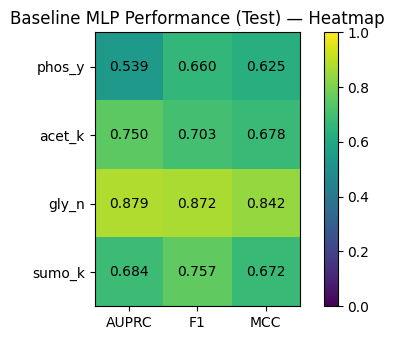

In [6]:
import matplotlib.pyplot as plt
import numpy as np

ptm = ["phos_y", "acet_k", "gly_n", "sumo_k"]
metrics = ["AUPRC", "F1", "MCC"]

data = np.array([
    [0.5390, 0.6602, 0.6254],
    [0.7497, 0.7026, 0.6782],
    [0.8790, 0.8716, 0.8421],
    [0.6836, 0.7567, 0.6723],
])

fig, ax = plt.subplots(figsize=(6.5, 3.5))
im = ax.imshow(data, vmin=0, vmax=1)

ax.set_xticks(np.arange(len(metrics)), labels=metrics)
ax.set_yticks(np.arange(len(ptm)), labels=ptm)
ax.set_title("Baseline MLP Performance (Test) — Heatmap")

# annotate cells
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax.text(j, i, f"{data[i, j]:.3f}", ha="center", va="center")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()